## Read the NetCDF file

In [ ]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


## Data Visualization

### Readig the data into Xarray

In [ ]:
# Convert xarray dataset to GeoDataFrame
data = xr.open_dataset(r'D:\master thesis\master thesis\air quality prediction\dataset\monthly average pollution\monthly_new.nc')

# preprocessing the data to replace the NaN values with the mean value
mean_t2m= data['t2m'].mean()
t2m = data['t2m'].fillna(mean_t2m)
null_mask = data['t2m'].isnull()
missing_count = null_mask.sum().item()
non_missing_count = (~null_mask).sum().item()


### Plotting the time series

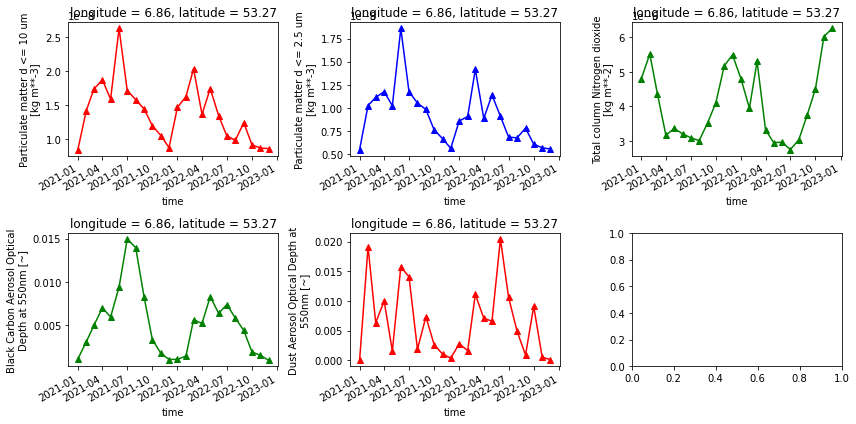

In [ ]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 3,figsize=(12, 6))

# collecting sample locations for visualizations
sample = data.isel(longitude = 0   , latitude = 1 )

sample['pm10'].plot.line("b-^",ax=axs[0][0], color='red')
sample['pm2p5'].plot.line("b-^",ax=axs[0][1],color='blue')
sample['tcno2'].plot.line("b-^",ax=axs[0][2],color='green')



sample['bcaod550'].plot.line("b-^",ax=axs[1][0],color='green')
sample['duaod550'].plot.line("b-^",ax=axs[1][1],color='red')

plt.subplots_adjust(hspace=0.5)

plt.tight_layout()
plt.show()


### Selecting the timestep and the data feature

In [ ]:
available_timesteps = data.time
time_steps = available_timesteps.values
time_step_labels = [np.datetime64(step).astype('datetime64[D]').astype(str) for step in time_steps]
time_step = '2022-03-01'  # Replace with the desired time step
lat = data.variables['latitude'][:]
lon = data.variables['longitude'][:]
# Select the data for the specific feature and time step
subset = data.pm10.sel(time=time_step)
min_= data['pm10'].min()
max_= data['pm10'].max()


In [ ]:
import ipywidgets as widgets
from IPython.display import display

time_step_dropdown = widgets.Dropdown(
    options=list(zip(time_step_labels, time_step)),
    description='Time Step:'
)

display(time_step_dropdown)

Dropdown(description='Time Step:', options=(('2021-01-01', '2'), ('2021-02-01', '0'), ('2021-03-01', '2'), ('2…

### Converting Xarray into the list formating

In [ ]:

# Assuming you have a 3D NumPy ndarray called "filled_pm2p5"
num_latitudes, num_longitudes = subset.shape

# Reshape the array into a 2D format with additional columns for longitude and latitude
reshaped_array = np.empty((num_latitudes * num_longitudes, 3))
index = 0

for lat_index, lat_value in enumerate(lat):
    for lon_index, lon_value in enumerate(lon):
        # reshaped and normalized array values
        reshaped_array[index] = [lat_value,lon_value,((subset[lat_index, lon_index]-min_)/(max_-min_))]
        index += 1

# (subset[lat_index, lon_index]-min)/(max-min)

### Visualization without interpolation

In [ ]:
import folium
import numpy as np
from folium.plugins import HeatMap
from branca.colormap import linear


# Define the bounding box of Germany
min_lat, max_lat = 47.3, 55.1  # Latitude bounds of Germany
min_lon, max_lon = 5.8, 15.2  # Longitude bounds of Germany

# Calculate the step size for latitude and longitude to create the grid
num_points = 20
step_lat = (max_lat - min_lat) / (num_points - 1)
step_lon = (max_lon - min_lon) / (num_points - 1)

# Create a list of latitude and longitude values for the grid
latitudes = [min_lat + step_lat * i for i in range(num_points)]
longitudes = [min_lon + step_lon * i for i in range(num_points)]

# Create a list to store the coordinates, state, city, and random PM2.5 measures for the grid
grid_data = reshaped_array

# Generate random PM2.5 measures and state/city information for each coordinate in the grid
#for lat in latitudes:
  #  for lon in longitudes:
    #    pm25_measure = np.random.uniform(0, 50)  # Replace 0 and 50 with your desired PM2.5 range
    #    state_name = "State"  # Replace with the state name corresponding to the coordinate
     #   city_name = "City"  # Replace with the city name corresponding to the coordinate
     #   grid_data.append([lat, lon, pm25_measure, state_name, city_name])

g = {
    0.0: 'blue',        # Low concentrations are blue
    0.3: 'green',       # Medium-low concentrations are green
    0.5: 'yellow',      # Medium concentrations are yellow
    0.7: 'orange',      # Medium-high concentrations are orange
    1.0: 'red',         # High concentrations are red
}

# Create a Folium Map centered on Germany
m = folium.Map(location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], zoom_start=6)

# Create a HeatMap layer using the PM2.5 concentration data
HeatMap([[point[0], point[1], point[2]] for point in grid_data], radius=15,gradient=g).add_to(m)

# Add a legend for the heatmap
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 120px; height: 120px;
                 background-color: rgba(255, 255, 255, 0.6);
                 z-index:9999; font-size:14px;
                 ">&nbsp; PM2.5 Concentration <br>
     &nbsp; Low &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
     &nbsp; Medium &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
     &nbsp; Medium-High &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>
     &nbsp; High &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
      </div>
     '''

m.get_root().html.add_child(folium.Element(legend_html))

# Add a color bar to the map
colormap = linear.PuRd_09.scale(0, 1)
colormap.caption = 'PM2.5 Concentration'
m.add_child(colormap)

# Save the map to an HTML file
m.save("custom_gradient_heatmap.html")

#HeatMap(normalized_data, radius=10, gradient=colormap).add_to(m)
# Save the map to an HTML file
m